# Example `LFPy.Cell(pt3d=True, **kwargs)`
Example utilizing the LFPy forward models module for predictions of
current dipole moment from a wiggly, variable diameter dendritic stick model set up in LFPy.
The passive stick receives sinusoid synaptic current input at its terminal
segment.

The example is meant to demonstrate how pt3d information can be utilized for forward-model predictions. 

Assumes an even number of pt3d points per electric segment!
NEURON pt3d info does not necessarily correspond with segment start and end points. 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import neuron
import LFPy
import lfpy_forward_models
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
def colorbar(fig, ax, im,
             width=0.01,
             height=1.0,
             hoffset=0.01,
             voffset=0.0,
             orientation='vertical'):
    '''
    draw colorbar without resizing the axes object to make room
    '''
    rect = np.array(ax.get_position().bounds)
    rect = np.array(ax.get_position().bounds)
    caxrect = [0] * 4
    caxrect[0] = rect[0] + rect[2] + hoffset * rect[2]
    caxrect[1] = rect[1] + voffset * rect[3]
    caxrect[2] = rect[2] * width
    caxrect[3] = rect[3] * height
    cax = fig.add_axes(caxrect)
    cb = fig.colorbar(im, cax=cax, orientation=orientation)
    return cb

In [4]:
# set seed
np.random.seed(1234)

###############################################################################
# Define SectionList that can be fed into LFPy.Cell
###############################################################################
morphology = neuron.h.SectionList()
sec = neuron.h.Section(name='cell')

# define a wiggly section geometry
n_pt3d = 201  # number of pt3d points from start- to end-point of section
A0_x = 10     # spatial amplitude of sinusoid along x
omega0_x = 10 # spatial frequency of sinusoid along x
A1_x = 5      # spatial amplitude of 2nd sinusoid along x
omega1_x = 50 # spatial frequency of 2nd sinusoid along x
omega_d = 25  # spatial frequency of diameter variability
A_d = 1       # amplitude of diameter variability
offset_d = 3  # offset in diameter > A_d

# specify geometry [um]
neuron.h.pt3dadd(neuron.h.Vector(A0_x * np.sin(2 * np.pi * omega0_x * np.arange(n_pt3d) / 1000) + 
                                 A1_x * np.sin(2 * np.pi * omega1_x * np.arange(n_pt3d) / 1000)),  # x (um)
                 neuron.h.Vector(np.zeros(n_pt3d)),                                                # y (um)
                 neuron.h.Vector(np.arange(n_pt3d)),                                               # z (um)
                 neuron.h.Vector(A_d * np.cos(2 * np.pi * np.arange(n_pt3d) * omega_d / 1000)
                                ) + offset_d,  # diam (um)
                 sec=sec)

# passive parameters and spatial discretization
sec.nseg = 20           # number of segments
sec.insert('pas')       # insert passive mechanism
for seg in sec:
    seg.pas.g = 0.0001  # passive resistivity [S/cm2]
    seg.pas.e = -65     # leak reversal potential [mV]
morphology.append(sec)

1.0

In [5]:
###############################################################################
# Create LFPy.Cell object
###############################################################################
lfpy_cell = LFPy.Cell(morphology=morphology,
                      passive=False,
                      cm=1.,     # membrane capacitance [uF/cm2]
                      Ra=1000.,  # cytoplasmic resistivity [ohm cm]
                      v_init=-65.,  # initial voltage [mV]
                      nsegs_method=None,
                      delete_sections=False,
                      tstop=100.,  # simulation duration [ms]
                      pt3d=True
                      )
# position cell so start coordinate is at (0, 0, 0)
lfpy_cell.set_pos(-lfpy_cell.xstart[0], 0, -lfpy_cell.zstart[0])

# feed in some oscillating current with random phase
for idx in range(lfpy_cell.totnsegs):
    stim = LFPy.StimIntElectrode(lfpy_cell, idx=idx,
                                 pptype='SinSyn', 
                                 delay=0, 
                                 freq=100, 
                                 phase=np.random.rand() * 2 * np.pi)

# CellGeometry object
cell = lfpy_forward_models.CellGeometry(
    x=np.c_[lfpy_cell.xstart, lfpy_cell.xend],
    y=np.c_[lfpy_cell.ystart, lfpy_cell.yend],
    z=np.c_[lfpy_cell.zstart, lfpy_cell.zend],
    d=lfpy_cell.diam
)

In [6]:
###############################################################################
# run simulation, compute measurement
###############################################################################
lfpy_cell.simulate(variable_dt=True,
                   rec_imem=True,
                   rec_vmem=True,
                  )

# copy some output to GeometryCell for plotting
cell.time = lfpy_cell.tvec
cell.V_m = lfpy_cell.vmem
cell.I_m = lfpy_cell.imem

In [7]:
###############################################################################
# Create forward model object and get linear response matrix
###############################################################################
# set up coordinates in x,z-plane (y=0)
dx = 1.
dz = 1.
X, Z = np.meshgrid(np.linspace(-20, 20, int(40 // dx) + 1),
                   np.linspace(130, 210, int(80 // dz) + 1))
x = X.flatten()
y = np.zeros(x.size)
z = Z.flatten()

# LineSourcePotential object, get mapping
lsp = lfpy_forward_models.LineSourcePotential(cell=cell, x=x, y=y, z=z)
M = lsp.get_response_matrix()

# extracellular potential at last time step in x,z-plane coordinates
V_e = M @ cell.I_m[:, -1]

In [8]:
###############################################################################
# compute extracellular potential using pt3d information
###############################################################################
# Mock up 2nd GeometryCell object which has the (n_pt3d - 1) number of virtual 
# segments but Section.nseg number of segments, 
# assuming: (n_pt3d - 1) % nseg == 0
cell_temp = lfpy_forward_models.CellGeometry(
    x=np.c_[lfpy_cell.x3d[0][:-1], lfpy_cell.x3d[0][1:]],
    y=np.c_[lfpy_cell.y3d[0][:-1], lfpy_cell.y3d[0][1:]],
    z=np.c_[lfpy_cell.z3d[0][:-1], lfpy_cell.z3d[0][1:]],
    d=np.c_[lfpy_cell.diam3d[0][:-1], lfpy_cell.diam3d[0][1:]]
)

# LineSourcePotential object, get mapping for all subcompartments
lsp2 = lfpy_forward_models.LineSourcePotential(cell=cell_temp, x=x, y=y, z=z)
M_temp = lsp2.get_response_matrix()

# Define response matrix from M2 with columns weighted by area of each frusta
n_pt3d_per_seg = (n_pt3d - 1) // lfpy_cell.totnsegs
M_pt3d = np.zeros_like(M)
for i in range(sec.nseg):
    inds = np.arange(i * n_pt3d_per_seg, (i + 1) * n_pt3d_per_seg)
    M_pt3d[:, i] = (M_temp[:, inds] @ cell_temp.area[inds] / 
                    cell_temp.area[inds].sum()).sum(axis=-1)

# Extracellular potential using pt3d information at last time step 
# in x,z-plane coordinates   
V_e_pt3d = M_pt3d @ cell.I_m[:, -1]

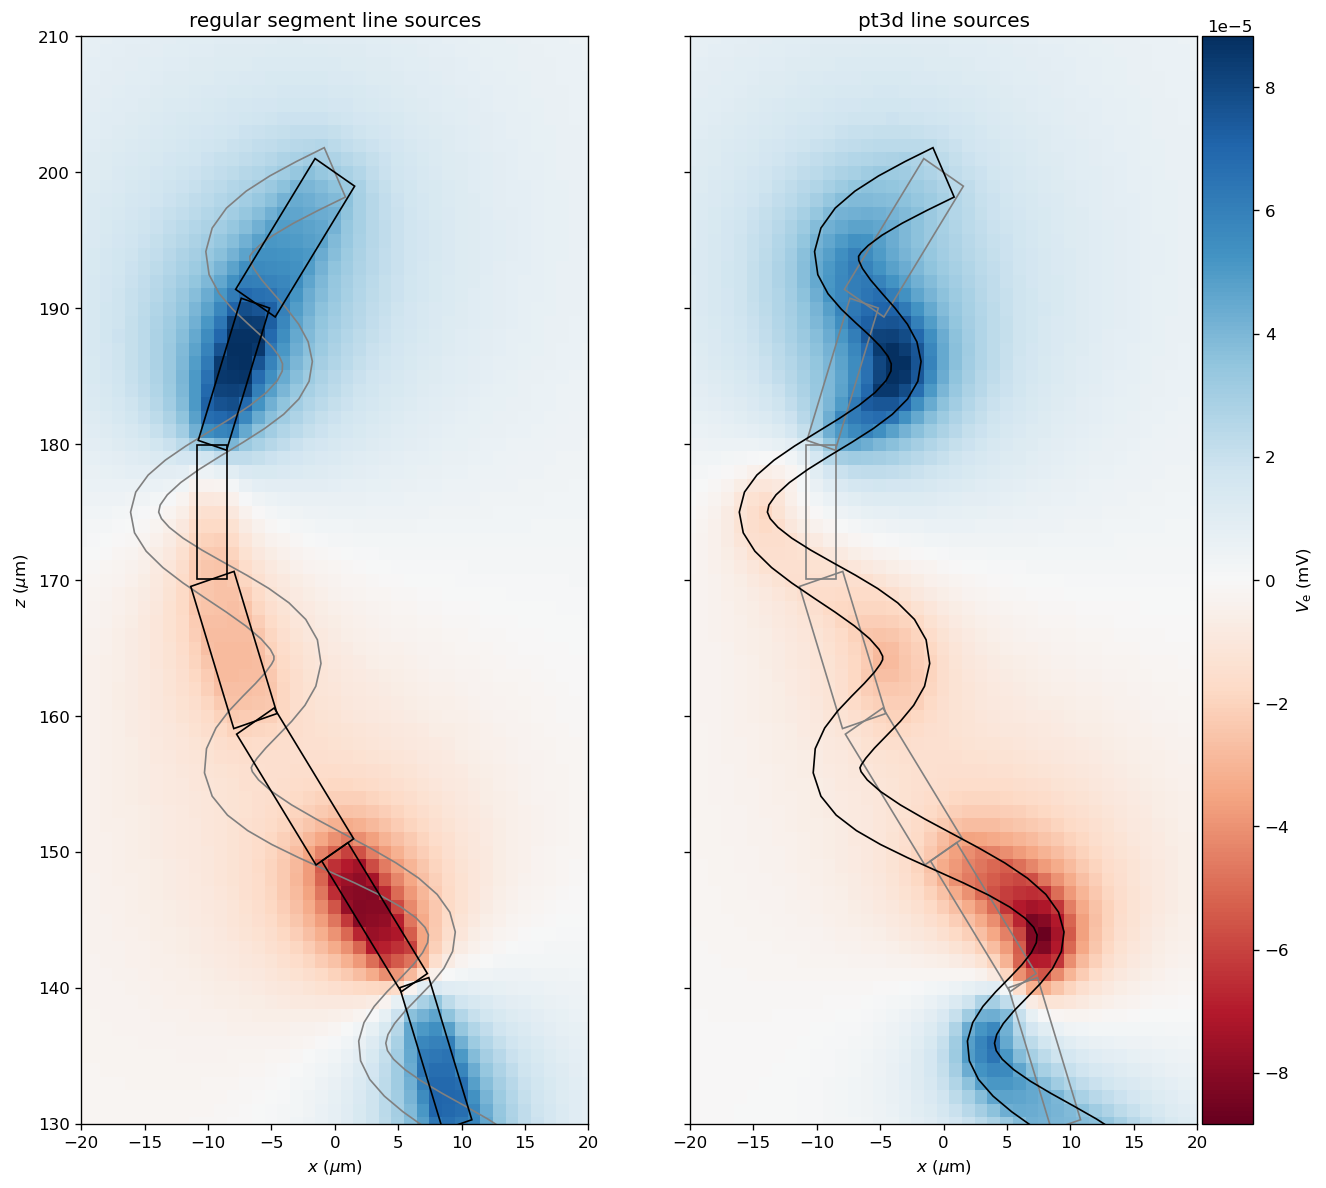

In [9]:
###############################################################################
# plot
###############################################################################
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 12), dpi=120)


ax0 = axes[0]
ax0.set_title('regular segment line sources')

# plot pcolormesh plot of V_e
im_V_e = ax0.pcolormesh(X, Z, V_e.reshape(X.shape), 
                        shading='auto', cmap='RdBu', 
                        vmin=-abs(V_e).max(), vmax=abs(V_e).max())


for xz in lfpy_cell.get_pt3d_polygons(projection=('x', 'z')):
    ax0.add_patch(plt.Polygon(np.stack(xz).T, ec='gray', fc='none'))

for xz in lfpy_cell.get_idx_polygons(projection=('x', 'z')):
    ax0.add_patch(plt.Polygon(np.stack(xz).T, ec='k', fc='none'))
    
ax0.set_xlim(X.min(), X.max())
ax0.set_ylim(Z.min(), Z.max())
ax0.set_xlabel(r'$x$ ($\mu$m)')
ax0.set_ylabel(r'$z$ ($\mu$m)')


ax1 = axes[1]
ax1.set_title('pt3d line sources')

# plot pcolormesh plot of V_e_pt3d
im_V_e_pt3d = ax1.pcolormesh(X, Z, V_e_pt3d.reshape(X.shape), 
                        shading='auto', cmap='RdBu', 
                        vmin=-abs(V_e).max(), vmax=abs(V_e).max())

for xz in lfpy_cell.get_idx_polygons(projection=('x', 'z')):
    ax1.add_patch(plt.Polygon(np.stack(xz).T, ec='gray', fc='none'))
    
for xz in lfpy_cell.get_pt3d_polygons(projection=('x', 'z')):
    ax1.add_patch(plt.Polygon(np.stack(xz).T, ec='k', fc='none'))

ax1.set_xlim(X.min(), X.max())
ax1.set_ylim(Z.min(), Z.max())
ax1.set_xlabel(r'$x$ ($\mu$m)')

cbar = colorbar(fig, ax1, im_V_e_pt3d, width=0.1)
cbar.set_label(r'$V_\mathrm{e}$ (mV)')